In [526]:
import sys
# !{sys.executable} -m pip install imblearn

In [654]:
import sys
#!{sys.executable} -m pip install xgboost

    100% |████████████████████████████████| 604kB 3.4MB/s ta 0:00:01
  Running setup.py bdist_wheel for xgboost ... done
  Stored in directory: /Users/lizhong/Library/Caches/pip/wheels/82/2d/9a/d9014a0add86cdad990022418a905ca9e93948ee8862ae755d
Successfully built xgboost
thinc 6.11.2 requires hypothesis<3,>=2, which is not installed.
thinc 6.11.2 requires pathlib<2.0.0,>=1.0.0, which is not installed.
spacy 2.0.11 requires pathlib, which is not installed.
smart-open 1.6.0 requires bz2file, which is not installed.
msgpack-numpy 0.4.3 requires msgpack>=0.3.0, which is not installed.
distributed 1.21.8 requires msgpack, which is not installed.
thinc 6.11.2 has requirement msgpack-numpy==0.4.1, but you'll have msgpack-numpy 0.4.3 which is incompatible.
thinc 6.11.2 has requirement msgpack-python==0.5.4, but you'll have msgpack-python 0.5.6 which is incompatible.
spacy 2.0.11 has requirement regex==2017.4.5, but you'll have regex 2018.6.21 which is incompatible.
spacy 2.0.11 has requirement

In [655]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.cross_validation import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from xgboost.sklearn import XGBClassifier

from datetime import datetime
from datetime import timedelta

In [528]:
train = pd.read_csv("./all/train.csv")
weather = pd.read_csv("./all/weather.csv")
spray = pd.read_csv("./all/spray.csv")

In [663]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null datetime64[ns]
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(5)
memory usage: 985.0+ KB


In [664]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
Date         14835 non-null datetime64[ns]
Time         14251 non-null object
Latitude     14835 non-null float64
Longitude    14835 non-null float64
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 463.7+ KB


In [529]:
train.shape, weather.shape, spray.shape

((10506, 12), (2944, 22), (14835, 4))

In [530]:
train['WnvPresent'].value_counts()

0    9955
1     551
Name: WnvPresent, dtype: int64

In [531]:
551 / (551 + 9955)

0.05244622120692937

In [662]:
train.Date = pd.to_datetime(df.Date)
weather.Date = pd.to_datetime(weather.Date)
spray.Date = pd.to_datetime(spray.Date)

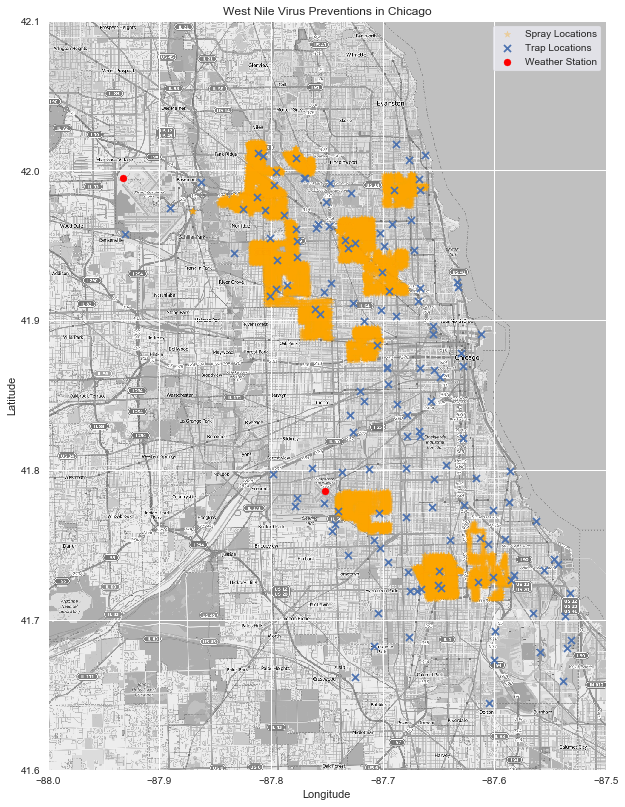

In [533]:
mapdata = np.loadtxt("./all/mapdata_copyright_openstreetmap_contributors.txt")
traps = pd.read_csv('./all/train.csv')[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

#plot map
plt.figure(figsize=(10,14))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)

#Spray locations
sprays = spray[['Longitude', 'Latitude']].drop_duplicates()
sprays = sprays[sprays['Latitude'] < 42.3]  #outliers excluded
plt.scatter(sprays['Longitude'], sprays['Latitude'], marker='*', color='orange',alpha=.3, label='Spray Locations')

#Trap locations
locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x', label='Trap Locations')

#Weather locations
plt.scatter(x = (-87.933, -87.752), y = (41.995, 41.786), marker='o', color='r', label='Weather Station')
            
plt.title('West Nile Virus Preventions in Chicago')
plt.legend(frameon=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('heatmap.png');

In [534]:
#check columns for the value with M
object_features = ['Tavg', 'Depart', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset',
       'CodeSum', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure',
       'SeaLevel', 'AvgSpeed']
for col in weather[object_features]:
    station_1 = len(weather[(weather[col].str.contains('M')) & (weather.Station==1)])
    print(col + ' has ' + str(station_1) + ' missing values at station 1')
    station_2 = len(weather[(weather[col].str.contains('M')) & (weather.Station==2)])
    print(col + ' has ' + str(station_2) + ' missing values at station 2')

Tavg has 0 missing values at station 1
Tavg has 11 missing values at station 2
Depart has 0 missing values at station 1
Depart has 1472 missing values at station 2
WetBulb has 3 missing values at station 1
WetBulb has 1 missing values at station 2
Heat has 0 missing values at station 1
Heat has 11 missing values at station 2
Cool has 0 missing values at station 1
Cool has 11 missing values at station 2
Sunrise has 0 missing values at station 1
Sunrise has 0 missing values at station 2
Sunset has 0 missing values at station 1
Sunset has 0 missing values at station 2
CodeSum has 3 missing values at station 1
CodeSum has 0 missing values at station 2
Depth has 0 missing values at station 1
Depth has 1472 missing values at station 2
Water1 has 1472 missing values at station 1
Water1 has 1472 missing values at station 2
SnowFall has 0 missing values at station 1
SnowFall has 1472 missing values at station 2
PrecipTotal has 0 missing values at station 1
PrecipTotal has 2 missing values at st

In [535]:
#check columns for values with T
for col in weather[object_features]:
    station_1 = len(weather[(weather[col].str.contains('T')) & (weather.Station==1)])
    print(col + ' has ' + str(station_1) + ' missing values at station 1')
    station_2 = len(weather[(weather[col].str.contains('T')) & (weather.Station==2)])
    print(col + ' has ' + str(station_2) + ' missing values at station 2')

Tavg has 0 missing values at station 1
Tavg has 0 missing values at station 2
Depart has 0 missing values at station 1
Depart has 0 missing values at station 2
WetBulb has 0 missing values at station 1
WetBulb has 0 missing values at station 2
Heat has 0 missing values at station 1
Heat has 0 missing values at station 2
Cool has 0 missing values at station 1
Cool has 0 missing values at station 2
Sunrise has 0 missing values at station 1
Sunrise has 0 missing values at station 2
Sunset has 0 missing values at station 1
Sunset has 0 missing values at station 2
CodeSum has 174 missing values at station 1
CodeSum has 179 missing values at station 2
Depth has 0 missing values at station 1
Depth has 0 missing values at station 2
Water1 has 0 missing values at station 1
Water1 has 0 missing values at station 2
SnowFall has 12 missing values at station 1
SnowFall has 0 missing values at station 2
PrecipTotal has 163 missing values at station 1
PrecipTotal has 155 missing values at station 2
S

In [536]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
Station        2944 non-null int64
Date           2944 non-null datetime64[ns]
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null object
Depart         2944 non-null object
DewPoint       2944 non-null int64
WetBulb        2944 non-null object
Heat           2944 non-null object
Cool           2944 non-null object
Sunrise        2944 non-null object
Sunset         2944 non-null object
CodeSum        2944 non-null object
Depth          2944 non-null object
Water1         2944 non-null object
SnowFall       2944 non-null object
PrecipTotal    2944 non-null object
StnPressure    2944 non-null object
SeaLevel       2944 non-null object
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null object
dtypes: datetime64[ns](1), float64(1), int64(5), object(15)
memory usage: 506.1+ KB


In [537]:
weather.select_dtypes(include='object').columns

Index(['Tavg', 'Depart', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset',
       'CodeSum', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure',
       'SeaLevel', 'AvgSpeed'],
      dtype='object')

In [538]:
#columns to replace values of M, T, - 
columns = ['Tavg', 'Depart', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset',
           'SnowFall', 'PrecipTotal', 'StnPressure','SeaLevel', 'AvgSpeed']

for column in columns:
    weather.replace({'M': None}, inplace = True)
    weather.replace({'T': '0.00001'}, inplace = True)
    weather.replace({'  T': '0.00001'}, inplace = True)
    weather.replace({'-': None}, inplace = True)

In [539]:
# I didn't find these columns useful at all
weather.drop(columns= ['CodeSum', 'Depth', 'Water1'],inplace=True)

In [540]:
#convert columns to float type and fill na with mean
for column in columns:
    weather[column] = weather[column].astype(float)
    weather[column] = weather[column].fillna(weather[column].mean(skipna = True))

In [541]:
#create new dataframe with the average of columns for the two weather stations
weather_both = pd.DataFrame()
station_1 = weather[weather['Station'] == 1].reset_index()
station_2 = weather[weather['Station'] == 2].reset_index()
weather_both['Date'] = station_1['Date']


def avg_station(df):
    for col in df:
        weather_both[col] = (station_1[col] + station_2[col])*.5

In [542]:
#apply function
avg_station(weather.drop(['Date','Station'],axis=1))

In [543]:
#create a column for the days since it last rained
weather_both["days_since_rain"] = 0
days = 0

for i in range(weather_both.shape[0]):
    if weather_both.loc[i,'PrecipTotal'] == 0:
        days = days + 1
        weather_both.loc[i,'days_since_rain'] = days
    else:
        weather_both.loc[i, 'days_since_rain'] = 0
        days=0

In [544]:
#check to make sure everything is good so far
weather_both.head(2)

,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,days_since_rain
0,2007-05-01,83.5,51.0,67.5,7.977242,51.0,56.5,0.0,2.5,464.32337,1848.173913,0.000034,0.0,29.14,29.820,2.20,26.0,9.4,1
1,2007-05-02,59.5,42.5,51.5,-0.522758,42.0,47.0,13.5,0.0,463.82337,1848.673913,0.000034,0.0,29.41,30.085,13.15,3.0,13.4,2


In [545]:
#set a new dataframe for the features i want to do a time lag on
var = ['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'SnowFall',
       'PrecipTotal', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed']

lag_features = weather_both[var]

In [546]:
#set the number of lags i want, these are the lags in days
lags = (1,3,7,14)

#set to a final dataframe
#.assign assigns new columns to the dataframe, after that is a list comprehension
#f'{col}_lag_{n}' <-- f' string feature to assign column name, its like .format()
#list comp <-- for every column shift down for every lag
final_weather = weather_both.assign(**{f'{col}_lag_{n}': 
                                       lag_features[col].shift(n) for n in lags for col in lag_features})

In [547]:
#merges the two datasets together (train and final weather data)
result = train.merge(final_weather, on='Date')

In [548]:
#function for how long a day is in minutes
def day_length(row):
    sunset = (round(row.Sunset / 100) * 60)
    sunrise = (round(row.Sunrise / 100) * 60)
    return int(abs(sunset - sunrise))

In [549]:
#apply the function
result['day_length'] = result.apply(day_length, axis=1)

In [550]:
result.select_dtypes(include='object').columns

Index(['Address', 'Species', 'Street', 'Trap', 'AddressNumberAndStreet'], dtype='object')

In [551]:
result.select_dtypes(include=['float64', 'int64']).columns

Index(['Block', 'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos',
       'WnvPresent', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'Sunrise', 'Sunset', 'SnowFall', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'days_since_rain', 'Tmax_lag_1', 'Tmin_lag_1', 'Tavg_lag_1',
       'DewPoint_lag_1', 'WetBulb_lag_1', 'SnowFall_lag_1',
       'PrecipTotal_lag_1', 'SeaLevel_lag_1', 'ResultSpeed_lag_1',
       'ResultDir_lag_1', 'AvgSpeed_lag_1', 'Tmax_lag_3', 'Tmin_lag_3',
       'Tavg_lag_3', 'DewPoint_lag_3', 'WetBulb_lag_3', 'SnowFall_lag_3',
       'PrecipTotal_lag_3', 'SeaLevel_lag_3', 'ResultSpeed_lag_3',
       'ResultDir_lag_3', 'AvgSpeed_lag_3', 'Tmax_lag_7', 'Tmin_lag_7',
       'Tavg_lag_7', 'DewPoint_lag_7', 'WetBulb_lag_7', 'SnowFall_lag_7',
       'PrecipTotal_lag_7', 'SeaLevel_lag_7', 'ResultSpeed_lag_7',
       'ResultDir_lag_7', 'AvgSpeed_lag_7', 'Tmax_lag_14', 'Tmin_lag_14',
      

In [552]:
columns_high_corr = abs(result.corr()["WnvPresent"]).sort_values(ascending=False).round(3).index[2:40]

In [553]:
result.shape

(10506, 75)

In [554]:
result["WnvPresent"].value_counts()

0    9955
1     551
Name: WnvPresent, dtype: int64

Select the five best features

In [555]:
#training_features = result.drop(columns=['WnvPresent', 'NumMosquitos'], axis = 1)
training_features = result[columns_high_corr]
training_target = result["WnvPresent"]

In [556]:
training_features.shape

(10506, 38)

In [557]:
x_train, x_test, y_train, y_test = train_test_split(training_features, training_target,
                                                  test_size = .2,
                                                  random_state=11, shuffle = True)

Oversampling 

In [658]:
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_mod, y_train_mod = sm.fit_sample(x_train, y_train)
x_test_mod, y_test_mod = sm.fit_sample(x_test, y_test)

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Logistic Regression

In [559]:
lg = LogisticRegression()

print("Cross validation on over sampled train data:\n",cross_val_score(lg, x_train_mod,y_train_mod,n_jobs=-1, cv = 10).round(3),"\n")

print("Cross validation on test data: \n", cross_val_score(lg, x_test,y_test,n_jobs=-1, cv = 10).round(3), "\n")

Cross validation on over sampled train data:
 [0.768 0.754 0.763 0.753 0.751 0.759 0.768 0.758 0.755 0.768] 

Cross validation on test data: 
 [0.948 0.948 0.948 0.948 0.952 0.952 0.952 0.952 0.952 0.952] 



In [560]:
lg.fit(x_train_mod, y_train_mod)
predicted = lg.predict(x_train_mod)
print("R2 score on train dataset: ", lg.score(x_train_mod, y_train_mod).round(3))
print("ROC score on train dataset: ", roc_auc_score(y_train_mod, predicted).round(3))

R2 score on train dataset:  0.762
ROC score on train dataset:  0.762


In [561]:
print("R2 score on test dataset: ", lg.score(x_test, y_test).round(3))
predicted = lg.predict(x_test)
print("ROC score on test dataset: ",roc_auc_score(y_test, predicted).round(3))

R2 score on test dataset:  0.704
ROC score on test dataset:  0.753


Gradient Boosting Classifier

In [646]:
gbc = GradientBoostingClassifier()

In [647]:
gbc = GradientBoostingClassifier()
print("Cross validation on train dataset: \n", cross_val_score(gbc, x_train_mod,y_train_mod, n_jobs=-1, cv = 10).round(3), "\n")
print("Cross validation on test dataset: \n", cross_val_score(gbc, x_test,y_test, n_jobs=-1, cv = 10).round(3), "\n")

Cross validation on train dataset: 
 [0.805 0.827 0.837 0.823 0.823 0.832 0.83  0.833 0.83  0.836] 

Cross validation on test dataset: 
 [0.957 0.943 0.948 0.943 0.948 0.957 0.952 0.948 0.952 0.943] 



In [648]:
gbc.fit(x_train_mod, y_train_mod)
predicted = gbc.predict(x_train_mod)
print("R2 score on train dataset: ", gbc.score(x_train_mod, y_train_mod).round(3))
print("ROC score on train dataset: ", roc_auc_score(y_train_mod ,predicted).round(3))

R2 score on train dataset:  0.834
ROC score on train dataset:  0.834


In [649]:
predicted = gbc.predict(x_test)
print("R2 score on test dataset: ", gbc.score(x_test, y_test).round(3))
print("ROC score on test dataset: ", roc_auc_score(y_test, predicted).round(3))

R2 score on test dataset:  0.765
ROC score on test dataset:  0.758


In [521]:
GradientBoostingClassifier()

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [623]:
# Using gridsearch CV to optimize results
score_function = make_scorer(roc_auc_score)
params_gbc = {
    "gbc__learning_rate"  : [1],
    "gbc__n_estimators"     : [10, 100, 300],
    "gbc__max_depth"  : [3, 10],
    "gbc__random_state"    : [42]
             }
steps_gbc = [('gbc', GradientBoostingClassifier())]
pipe_gbc = Pipeline(steps = steps_gbc)
gs_gbc = GridSearchCV(pipe_gbc, param_grid = params_gbc , scoring = score_function, verbose=1)

In [624]:
gs_gbc.fit(x_train_mod, y_train_mod)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  2.7min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('gbc', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
 ...     presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gbc__learning_rate': [1], 'gbc__n_estimators': [10, 100, 300], 'gbc__max_depth': [3, 10], 'gbc__random_state': [42]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=1)

In [625]:
gs_gbc.best_params_

{'gbc__learning_rate': 1,
 'gbc__max_depth': 10,
 'gbc__n_estimators': 300,
 'gbc__random_state': 42}

In [628]:
# Test gbc using gridserachcv updated results
gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, random_state=42, max_depth=10)
gbc.fit(x_train_mod, y_train_mod)
predicted = gbc.predict(x_train_mod)
print("R2 score on train dataset: ", gbc.score(x_train_mod, y_train_mod).round(3))
print("ROC score on train dataset: ", roc_auc_score(y_train_mod ,predicted).round(3))

R2 score on train dataset:  0.958
ROC score on train dataset:  0.958


In [629]:
predicted = gbc.predict(x_test)
print("R2 score on test dataset: ", gbc.score(x_test, y_test).round(3))
print("ROC score on test dataset: ", roc_auc_score(y_test, predicted).round(3))

R2 score on test dataset:  0.897
ROC score on test dataset:  0.627


In [ ]:
# Fine tune on accuracy score:
# {'gbc__learning_rate': 0.1,
# 'gbc__max_depth': 10,
# 'gbc__n_estimators': 500,
# 'gbc__random_state': 42}
# R2 score on train dataset:  0.903
# ROC score on train dataset:  0.903
# R2 score on test dataset:  0.846
# ROC score on test dataset:  0.682   too bad on ROC score, switch to ROC score for score function

In [ ]:
# gbc = GradientBoostingClassifier(learning_rate=1, n_estimators=100, random_state=42, max_depth=10)
# R2 score on train dataset:  0.962
# ROC score on train dataset:  0.962
# R2 score on test dataset:  0.903
# ROC score on test dataset:  0.625

In [ ]:
# gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500, random_state=42, max_depth=10)
# R2 score on train dataset:  0.965
# ROC score on train dataset:  0.965
# R2 score on test dataset:  0.92
# ROC score on test dataset:  0.607

Random Forest Classifier

In [566]:
rfc = RandomForestClassifier()
print("Cross validation score on train dataset: ", cross_val_score(rfc, x_train_mod,y_train_mod, n_jobs=-1).round(3), "\n")
print("Cross validation score on test dataset: ", cross_val_score(rfc, x_test,y_test, n_jobs=-1).round(3), "\n")

Cross validation score on train dataset:  [0.848 0.86  0.864] 

Cross validation score on test dataset:  [0.939 0.933 0.934] 



In [567]:
rfc.fit(x_train_mod, y_train_mod)
print("R2 score on train dataset: ", rfc.score(x_train_mod, y_train_mod).round(3))
predicted = rfc.predict(x_train)
print("ROC score on train dataset: ", roc_auc_score(y_train, predicted).round(3))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
print("R2 score on test dataset: ", rfc.score(x_test, y_test).round(3))
predicted = rfc.predict(x_test)
print("ROC score on test dataset: ", roc_auc_score(y_test, predicted).round(3))

** XGBOOST Model **

In [661]:
xgb = XGBClassifier(max_depth=7,
                           min_child_weight=1,
                           learning_rate=0.1,
                           n_estimators=500,
                           silent=True,
                           objective='binary:logistic',
                           gamma=0,
                           max_delta_step=0,
                           subsample=1,
                           colsample_bytree=1,
                           colsample_bylevel=1,
                           reg_alpha=0,
                           reg_lambda=0,
                           scale_pos_weight=1,
                           seed=1,
                           missing=None)
xgb.fit(x_train_mod, y_train_mod, eval_metric='auc', verbose=False, early_stopping_rounds=100)
y_pre = xgb.predict(x_test)
y_pro = xgb.predict_proba(x_test)[:, 1]


IndexError: list index out of range

** Create Sumission File for Kaggle **

In [570]:
test_kaggle = pd.read_csv("./all/test.csv")

In [571]:
test_kaggle.shape

(116293, 11)

In [572]:
test_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
Id                        116293 non-null int64
Date                      116293 non-null object
Address                   116293 non-null object
Species                   116293 non-null object
Block                     116293 non-null int64
Street                    116293 non-null object
Trap                      116293 non-null object
AddressNumberAndStreet    116293 non-null object
Latitude                  116293 non-null float64
Longitude                 116293 non-null float64
AddressAccuracy           116293 non-null int64
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


In [573]:
# We need to apply the same feature engineering steps for better prediction

In [574]:
test_kaggle.Date = pd.to_datetime(test_kaggle.Date)

In [575]:
columns_high_corr

Index(['day_length', 'DewPoint_lag_1', 'Sunrise', 'WetBulb_lag_1',
       'AvgSpeed_lag_14', 'Tmin_lag_1', 'DewPoint_lag_7', 'DewPoint',
       'Tavg_lag_14', 'ResultSpeed_lag_7', 'Tmin_lag_14', 'WetBulb_lag_7',
       'WetBulb', 'ResultSpeed_lag_14', 'Tmin_lag_7', 'WetBulb_lag_14',
       'Tavg_lag_1', 'SeaLevel_lag_3', 'Tmin', 'Tmax_lag_14', 'Sunset',
       'Tavg_lag_7', 'Tavg', 'DewPoint_lag_14', 'Longitude', 'AvgSpeed_lag_7',
       'Cool', 'Depart', 'Heat', 'DewPoint_lag_3', 'Tmax_lag_1',
       'PrecipTotal_lag_1', 'Tmax', 'ResultSpeed', 'ResultSpeed_lag_1',
       'ResultDir_lag_1', 'Tmax_lag_7', 'PrecipTotal_lag_3'],
      dtype='object')

In [576]:
test_feat_eng = test_kaggle.merge(final_weather, on='Date')
test_feat_eng['day_length'] = test_feat_eng.apply(day_length, axis=1)

In [577]:
test_feat_eng.shape

(116293, 74)

In [578]:
columns_high_corr

Index(['day_length', 'DewPoint_lag_1', 'Sunrise', 'WetBulb_lag_1',
       'AvgSpeed_lag_14', 'Tmin_lag_1', 'DewPoint_lag_7', 'DewPoint',
       'Tavg_lag_14', 'ResultSpeed_lag_7', 'Tmin_lag_14', 'WetBulb_lag_7',
       'WetBulb', 'ResultSpeed_lag_14', 'Tmin_lag_7', 'WetBulb_lag_14',
       'Tavg_lag_1', 'SeaLevel_lag_3', 'Tmin', 'Tmax_lag_14', 'Sunset',
       'Tavg_lag_7', 'Tavg', 'DewPoint_lag_14', 'Longitude', 'AvgSpeed_lag_7',
       'Cool', 'Depart', 'Heat', 'DewPoint_lag_3', 'Tmax_lag_1',
       'PrecipTotal_lag_1', 'Tmax', 'ResultSpeed', 'ResultSpeed_lag_1',
       'ResultDir_lag_1', 'Tmax_lag_7', 'PrecipTotal_lag_3'],
      dtype='object')

In [579]:
test_feat_eng = test_feat_eng[columns_high_corr]
test_feat_eng.shape

(116293, 38)

In [580]:
test_feat_eng.shape

(116293, 38)

In [650]:
test_kaggle_pred = gbc.predict_proba(test_feat_eng)
test_kaggle_pred[0:5]

array([[0.98309036, 0.01690964],
       [0.98309036, 0.01690964],
       [0.98309036, 0.01690964],
       [0.98309036, 0.01690964],
       [0.98309036, 0.01690964]])

** GBC submission **

In [651]:
submission = pd.DataFrame(gbc.predict_proba(test_feat_eng)[:,1], columns = ['WnvPresent'])

In [652]:
submission.set_index(np.arange(1, test_feat_eng.shape[0] + 1), inplace=True)
submission = submission.reset_index().rename(columns = {'index':'Id'})
submission.to_csv('./submission_gbc_default.csv', index = False)

In [653]:
pd_test_pred.value_counts()

0    82117
1    34176
dtype: int64

In [585]:
# linear regression
44504 / (71789 + 44504)

0.38268855391124146

In [586]:
71789 + 44504

116293